### **코드 구동 전에 꼭 주석해제하고 설치해주세요! 설치 후에는 주석 처리 권장**

In [3]:
# !pip show scipy
# !pip install nltk
# !pip install pandas
# !pip install contractions
# nltk.download('punkt') # 오래 걸림..
# nltk.download('omw-1.4')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# !pip install pyLDAvis
# !pip install gensim
# !pip install scikit-learn

### 사용 라이브러리들

In [4]:
import re
import os
import nltk
import string
import gensim
import pyLDAvis
import numpy as np
import contractions
import pandas as pd
from tqdm import tqdm
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pyLDAvis.gensim as gensimvis
from matplotlib import pyplot as plt
from gensim import corpora, models
from gensim.models import doc2vec
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.doc2vec import TaggedDocument
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None) # Pandas 전체 열 확인
pd.set_option('display.max_rows', None) # Pandas 전체 행 확인

### 1. 데이터 로딩

In [6]:
df = pd.read_csv("./LDA-Workspace/1. Data/Flipkart/df_LG_refri.csv") # 로드할 데이터의 (상대 or 절대) 경로를 지정
# df = pd.read_csv("./1. Data/Amazon/Amazon_LG_TV_review.csv") # 로드할 데이터의 (상대 or 절대) 경로를 지정
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,Very poor cooling,"Certified Buyer, Darbhanga",1 month ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
1,1,Not good product,"Certified Buyer, Bangarapet",2 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
2,2,Worst experience to buy filp kart... over heat...,"Certified Buyer, Coimbatore",5 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
3,3,"Worst quality wast of money, no return option","Certified Buyer, Tirupati",6 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
4,4,Refrigerator base not fitting properly,"Certified Buyer, Noida",6 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...


#### 옵션) 별점, 지역 등을 기준으로 필터링하실 분들은 아래에 코드 추가해서 진행 바랍니다

In [8]:
# df = df[df["star"] == 5] # 예시. 별점으로 분류할 경우
# df.head()

### 2. 데이터 전처리
1. 결측 데이터 여부 확인
1-2. 결측 데이터 확인시 다른 데이터(공백이나 0 등)로 대체
2. 이모지 제거 -> 텍스트 전처리 시작
3. 소문자 변환 
4. 수축형 확장
5. 구두점 제거
6. 불용어 제거
7. 표제어 추출
8. 단일 글자 제거
9. 숫자 제거

---
- 특정 데이터만 전처리를 원할 경우 코드 수정해서 사용해주세요! (예. df['특정열'])

In [10]:
# 로딩한 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1147 non-null   int64 
 1   text        1147 non-null   object
 2   state       1147 non-null   object
 3   date        1147 non-null   object
 4   star        1147 non-null   int64 
 5   hp_data     1147 non-null   object
dtypes: int64(2), object(4)
memory usage: 53.9+ KB


#### 1) 결측 데이터 여부 확인

In [12]:
df.isnull().sum()

Unnamed: 0    0
text          0
state         0
date          0
star          0
hp_data       0
dtype: int64

#### 1-2) 결측 데이터 대체
- 임시 방안

In [14]:
df = df.fillna('') # 결측치가 있는 경우
df.isnull().sum() # 결측치 데이터 여부 재확인

Unnamed: 0    0
text          0
state         0
date          0
star          0
hp_data       0
dtype: int64

#### 2) 이모지 제거
- 영어 제외 언어들도 제거?
  - 아스키(American ~) 코드를 기준으로 제거했기 때문에 다른 언어들도 함께 제거되는 것으로 추정

In [16]:
# 텍스트에서 이모지를 제거하는 함수
# 아스키 코드로 변환 후 제거
def rmEmoji_ascii(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

# DataFrame의 모든 문자열에 적용
def df_remove_emoji(df):
    return df.map(lambda x: rmEmoji_ascii(x) if isinstance(x, str) else x)

In [17]:
# Before
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,Very poor cooling,"Certified Buyer, Darbhanga",1 month ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
1,1,Not good product,"Certified Buyer, Bangarapet",2 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
2,2,Worst experience to buy filp kart... over heat...,"Certified Buyer, Coimbatore",5 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
3,3,"Worst quality wast of money, no return option","Certified Buyer, Tirupati",6 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
4,4,Refrigerator base not fitting properly,"Certified Buyer, Noida",6 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...


In [18]:
# After
df = df_remove_emoji(df)
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,Very poor cooling,"Certified Buyer, Darbhanga",1 month ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
1,1,Not good product,"Certified Buyer, Bangarapet",2 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
2,2,Worst experience to buy filp kart... over heat...,"Certified Buyer, Coimbatore",5 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
3,3,"Worst quality wast of money, no return option","Certified Buyer, Tirupati",6 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
4,4,Refrigerator base not fitting properly,"Certified Buyer, Noida",6 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...


#### 3) 소문자 변환

In [20]:
# DataFrame의 모든 열에 대해 문자열을 소문자로 변환하는 함수
# 문자열이 아닌 경우는 그대로 유지
def df_lowercase(df):
    return df.map(lambda x: x.lower() if isinstance(x, str) else x)

In [21]:
# Before
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,Very poor cooling,"Certified Buyer, Darbhanga",1 month ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
1,1,Not good product,"Certified Buyer, Bangarapet",2 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
2,2,Worst experience to buy filp kart... over heat...,"Certified Buyer, Coimbatore",5 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
3,3,"Worst quality wast of money, no return option","Certified Buyer, Tirupati",6 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...
4,4,Refrigerator base not fitting properly,"Certified Buyer, Noida",6 months ago,1,LG 185 L Direct Cool Single Door 5 Star Refrig...


In [22]:
# After
df = df_lowercase(df)
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,very poor cooling,"certified buyer, darbhanga",1 month ago,1,lg 185 l direct cool single door 5 star refrig...
1,1,not good product,"certified buyer, bangarapet",2 months ago,1,lg 185 l direct cool single door 5 star refrig...
2,2,worst experience to buy filp kart... over heat...,"certified buyer, coimbatore",5 months ago,1,lg 185 l direct cool single door 5 star refrig...
3,3,"worst quality wast of money, no return option","certified buyer, tirupati",6 months ago,1,lg 185 l direct cool single door 5 star refrig...
4,4,refrigerator base not fitting properly,"certified buyer, noida",6 months ago,1,lg 185 l direct cool single door 5 star refrig...


#### 4) 수축형 확장
- don't -> do not, aren't -> are not, etc 

In [24]:
# DataFrame의 모든 문자열 열에서 수축형을 확장하는 함수.
# 문자열이 아닌 경우는 그대로 유지
def df_expand_contractions(df):
     return df.map(lambda x: contractions.fix(x) if isinstance(x, str) else x)

In [25]:
# Before
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,very poor cooling,"certified buyer, darbhanga",1 month ago,1,lg 185 l direct cool single door 5 star refrig...
1,1,not good product,"certified buyer, bangarapet",2 months ago,1,lg 185 l direct cool single door 5 star refrig...
2,2,worst experience to buy filp kart... over heat...,"certified buyer, coimbatore",5 months ago,1,lg 185 l direct cool single door 5 star refrig...
3,3,"worst quality wast of money, no return option","certified buyer, tirupati",6 months ago,1,lg 185 l direct cool single door 5 star refrig...
4,4,refrigerator base not fitting properly,"certified buyer, noida",6 months ago,1,lg 185 l direct cool single door 5 star refrig...


In [26]:
# After
df = df_expand_contractions(df)
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,very poor cooling,"certified buyer, darbhanga",1 month ago,1,lg 185 l direct cool single door 5 star refrig...
1,1,not good product,"certified buyer, bangarapet",2 months ago,1,lg 185 l direct cool single door 5 star refrig...
2,2,worst experience to buy filp kart... over heat...,"certified buyer, coimbatore",5 months ago,1,lg 185 l direct cool single door 5 star refrig...
3,3,"worst quality wast of money, no return option","certified buyer, tirupati",6 months ago,1,lg 185 l direct cool single door 5 star refrig...
4,4,refrigerator base not fitting properly,"certified buyer, noida",6 months ago,1,lg 185 l direct cool single door 5 star refrig...


#### 5) 구두점 제거
- ?,!. 과 같이 텍스트 분석에 불필요한 요소들 제거
- 필요시, 해당 부분은 일부 데이터를 제외하고 적용되도록 수정해서 사용 요망..(날짜, 모델명 등)

In [28]:
def df_remove_punctuation(df):
    return df.map(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if isinstance(x, str) else x)

In [29]:
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,very poor cooling,"certified buyer, darbhanga",1 month ago,1,lg 185 l direct cool single door 5 star refrig...
1,1,not good product,"certified buyer, bangarapet",2 months ago,1,lg 185 l direct cool single door 5 star refrig...
2,2,worst experience to buy filp kart... over heat...,"certified buyer, coimbatore",5 months ago,1,lg 185 l direct cool single door 5 star refrig...
3,3,"worst quality wast of money, no return option","certified buyer, tirupati",6 months ago,1,lg 185 l direct cool single door 5 star refrig...
4,4,refrigerator base not fitting properly,"certified buyer, noida",6 months ago,1,lg 185 l direct cool single door 5 star refrig...


In [30]:
df = df_remove_punctuation(df)
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,very poor cooling,certified buyer darbhanga,1 month ago,1,lg 185 l direct cool single door 5 star refrig...
1,1,not good product,certified buyer bangarapet,2 months ago,1,lg 185 l direct cool single door 5 star refrig...
2,2,worst experience to buy filp kart over heating...,certified buyer coimbatore,5 months ago,1,lg 185 l direct cool single door 5 star refrig...
3,3,worst quality wast of money no return option,certified buyer tirupati,6 months ago,1,lg 185 l direct cool single door 5 star refrig...
4,4,refrigerator base not fitting properly,certified buyer noida,6 months ago,1,lg 185 l direct cool single door 5 star refrig...


#### 6) 불용어 제거
- nltk 불용어 사전 적용

In [32]:
# Before
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,very poor cooling,certified buyer darbhanga,1 month ago,1,lg 185 l direct cool single door 5 star refrig...
1,1,not good product,certified buyer bangarapet,2 months ago,1,lg 185 l direct cool single door 5 star refrig...
2,2,worst experience to buy filp kart over heating...,certified buyer coimbatore,5 months ago,1,lg 185 l direct cool single door 5 star refrig...
3,3,worst quality wast of money no return option,certified buyer tirupati,6 months ago,1,lg 185 l direct cool single door 5 star refrig...
4,4,refrigerator base not fitting properly,certified buyer noida,6 months ago,1,lg 185 l direct cool single door 5 star refrig...


In [33]:
# 불용어 목록 가져오기
stop_words = set(stopwords.words('english'))

In [34]:
# 불용어 제거 함수
def remove_stopwords(text):
    if isinstance(text, str):
        words = word_tokenize(text)  # 텍스트를 단어로 토큰화
        filtered_words = [word for word in words if word.lower() not in stop_words]  # 불용어 제거
        return ' '.join(filtered_words)  # 필터링된 단어들을 다시 하나의 문자열로 결합
    else:
        return text  # 문자열이 아닌 경우 그대로 반환

def df_remove_stopwords(df):
    return df.map(remove_stopwords)

In [35]:
# Before
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,very poor cooling,certified buyer darbhanga,1 month ago,1,lg 185 l direct cool single door 5 star refrig...
1,1,not good product,certified buyer bangarapet,2 months ago,1,lg 185 l direct cool single door 5 star refrig...
2,2,worst experience to buy filp kart over heating...,certified buyer coimbatore,5 months ago,1,lg 185 l direct cool single door 5 star refrig...
3,3,worst quality wast of money no return option,certified buyer tirupati,6 months ago,1,lg 185 l direct cool single door 5 star refrig...
4,4,refrigerator base not fitting properly,certified buyer noida,6 months ago,1,lg 185 l direct cool single door 5 star refrig...


In [36]:
# After
df = df_remove_stopwords(df)
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,poor cooling,certified buyer darbhanga,1 month ago,1,lg 185 l direct cool single door 5 star refrig...
1,1,good product,certified buyer bangarapet,2 months ago,1,lg 185 l direct cool single door 5 star refrig...
2,2,worst experience buy filp kart heating issue r...,certified buyer coimbatore,5 months ago,1,lg 185 l direct cool single door 5 star refrig...
3,3,worst quality wast money return option,certified buyer tirupati,6 months ago,1,lg 185 l direct cool single door 5 star refrig...
4,4,refrigerator base fitting properly,certified buyer noida,6 months ago,1,lg 185 l direct cool single door 5 star refrig...


#### 7) 표제어 추출
- 단어 원형 추출
  - children -> child, went -> go, etc

In [38]:
# nltk의 pos_tag와 wordnet의 태그 매핑 함수
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# 모든 문자열에 대해 표제어 추출을 수행하는 함수
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer() # 텍스트를 토큰화
    tokens = word_tokenize(text) # 품사 태깅
    tagged_tokens = nltk.pos_tag(tokens) # 각 단어를 표제어 추출 (품사 정보 고려)
    lemmatized_tokens = []
    for token, tag in tagged_tokens:
        wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN  # 기본적으로 명사 처리
        lemmatized_tokens.append(lemmatizer.lemmatize(token, pos=wordnet_pos))
    return ' '.join(lemmatized_tokens)

# DataFrame의 모든 문자열에 대해 lemmatize_text 함수 수행
# 문자열이 아닌 경우는 그대로 유지
def df_lemmatize(df):
    return df.map(lambda x: lemmatize_text(x) if isinstance(x, str) else x)

In [39]:
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,poor cooling,certified buyer darbhanga,1 month ago,1,lg 185 l direct cool single door 5 star refrig...
1,1,good product,certified buyer bangarapet,2 months ago,1,lg 185 l direct cool single door 5 star refrig...
2,2,worst experience buy filp kart heating issue r...,certified buyer coimbatore,5 months ago,1,lg 185 l direct cool single door 5 star refrig...
3,3,worst quality wast money return option,certified buyer tirupati,6 months ago,1,lg 185 l direct cool single door 5 star refrig...
4,4,refrigerator base fitting properly,certified buyer noida,6 months ago,1,lg 185 l direct cool single door 5 star refrig...


In [40]:
# After
df = df_lemmatize(df)
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,poor cooling,certify buyer darbhanga,1 month ago,1,lg 185 l direct cool single door 5 star refrig...
1,1,good product,certify buyer bangarapet,2 month ago,1,lg 185 l direct cool single door 5 star refrig...
2,2,bad experience buy filp kart heat issue refrig...,certify buyer coimbatore,5 month ago,1,lg 185 l direct cool single door 5 star refrig...
3,3,bad quality wast money return option,certify buyer tirupati,6 month ago,1,lg 185 l direct cool single door 5 star refrig...
4,4,refrigerator base fit properly,certify buyer noida,6 month ago,1,lg 185 l direct cool single door 5 star refrig...


#### 8) 숫자 데이터 제거
- 마찬가지로 필요시 해당 부분은 일부 데이터를 제외하고 적용되도록 수정해서 사용 요망..(날짜, 모델명 등)

In [42]:
# 숫자 제거 함수
def remove_numbers_from_text(text):
    cleaned_text = re.sub(r'\d+', '', text) # 숫자를 제거
    
    # 중복된 공백 제거 및 텍스트 정리
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text if cleaned_text else ""

def df_remove_numbers(df):
    return df.map(lambda x: remove_numbers_from_text(x) if isinstance(x, str) else x)

In [43]:
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,poor cooling,certify buyer darbhanga,1 month ago,1,lg 185 l direct cool single door 5 star refrig...
1,1,good product,certify buyer bangarapet,2 month ago,1,lg 185 l direct cool single door 5 star refrig...
2,2,bad experience buy filp kart heat issue refrig...,certify buyer coimbatore,5 month ago,1,lg 185 l direct cool single door 5 star refrig...
3,3,bad quality wast money return option,certify buyer tirupati,6 month ago,1,lg 185 l direct cool single door 5 star refrig...
4,4,refrigerator base fit properly,certify buyer noida,6 month ago,1,lg 185 l direct cool single door 5 star refrig...


In [44]:
df = df_remove_numbers(df)
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,poor cooling,certify buyer darbhanga,month ago,1,lg l direct cool single door star refrigerator...
1,1,good product,certify buyer bangarapet,month ago,1,lg l direct cool single door star refrigerator...
2,2,bad experience buy filp kart heat issue refrig...,certify buyer coimbatore,month ago,1,lg l direct cool single door star refrigerator...
3,3,bad quality wast money return option,certify buyer tirupati,month ago,1,lg l direct cool single door star refrigerator...
4,4,refrigerator base fit properly,certify buyer noida,month ago,1,lg l direct cool single door star refrigerator...


#### 9) 의미 없는 단일 글자 데이터 제거

In [46]:
# 정규 표현식을 사용하여 한 글자 단어를 제거
def remove_single_characters(text):
    cleaned_text = re.sub(r'\b\w{1}\b', '', text)
    # 중복된 공백 제거
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# 마찬가지로 DataFrame에 적용
def df_remove_single_characters(df):
    return df.map(lambda x: remove_single_characters(x) if isinstance(x, str) else x)

In [47]:
# Before
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,poor cooling,certify buyer darbhanga,month ago,1,lg l direct cool single door star refrigerator...
1,1,good product,certify buyer bangarapet,month ago,1,lg l direct cool single door star refrigerator...
2,2,bad experience buy filp kart heat issue refrig...,certify buyer coimbatore,month ago,1,lg l direct cool single door star refrigerator...
3,3,bad quality wast money return option,certify buyer tirupati,month ago,1,lg l direct cool single door star refrigerator...
4,4,refrigerator base fit properly,certify buyer noida,month ago,1,lg l direct cool single door star refrigerator...


In [48]:
# After
df = df_remove_single_characters(df)
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,poor cooling,certify buyer darbhanga,month ago,1,lg direct cool single door star refrigerator b...
1,1,good product,certify buyer bangarapet,month ago,1,lg direct cool single door star refrigerator b...
2,2,bad experience buy filp kart heat issue refrig...,certify buyer coimbatore,month ago,1,lg direct cool single door star refrigerator b...
3,3,bad quality wast money return option,certify buyer tirupati,month ago,1,lg direct cool single door star refrigerator b...
4,4,refrigerator base fit properly,certify buyer noida,month ago,1,lg direct cool single door star refrigerator b...


#### 옵션) 특정 단어들을 제외하고 싶을 경우
- +) 특정 품사만 추출하고파! -> 표제어 추출 함수 응용하면 될지도..?
- 표제어 추출이 일부 미흡

In [50]:
# 예시 코드
# stop_words.update(['lg','flipkart']) # 불용어 사전 업데이트 
# df = df_remove_stopwords(df)
# df.head()

### 3. 텍스트 데이터 토큰화

In [52]:
# 텍스트를 토큰화하는 함수
def tokenize_text(text):
    
    return word_tokenize(text)

# DataFrame의 모든 문자열을 토큰화하는 함수.
def df_tokenize(df):
    return df.map(lambda x: tokenize_text(x) if isinstance(x, str) else x)

In [53]:
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,poor cooling,certify buyer darbhanga,month ago,1,lg direct cool single door star refrigerator b...
1,1,good product,certify buyer bangarapet,month ago,1,lg direct cool single door star refrigerator b...
2,2,bad experience buy filp kart heat issue refrig...,certify buyer coimbatore,month ago,1,lg direct cool single door star refrigerator b...
3,3,bad quality wast money return option,certify buyer tirupati,month ago,1,lg direct cool single door star refrigerator b...
4,4,refrigerator base fit properly,certify buyer noida,month ago,1,lg direct cool single door star refrigerator b...


In [54]:
df = df_tokenize(df)
df.head()

,Unnamed: 0,text,state,date,star,hp_data
0,0,"[poor, cooling]","[certify, buyer, darbhanga]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige..."
1,1,"[good, product]","[certify, buyer, bangarapet]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige..."
2,2,"[bad, experience, buy, filp, kart, heat, issue...","[certify, buyer, coimbatore]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige..."
3,3,"[bad, quality, wast, money, return, option]","[certify, buyer, tirupati]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige..."
4,4,"[refrigerator, base, fit, properly]","[certify, buyer, noida]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige..."


### 4. 클러스터 선정

#### ✨분석 및 벡터화 진행할 텍스트 데이터 열 선택

In [57]:
column_name = "text" # 분석 진행할 텍스트 데이터 열 선택
display(df.head()) # 열 이름 확인용

,Unnamed: 0,text,state,date,star,hp_data
0,0,"[poor, cooling]","[certify, buyer, darbhanga]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige..."
1,1,"[good, product]","[certify, buyer, bangarapet]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige..."
2,2,"[bad, experience, buy, filp, kart, heat, issue...","[certify, buyer, coimbatore]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige..."
3,3,"[bad, quality, wast, money, return, option]","[certify, buyer, tirupati]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige..."
4,4,"[refrigerator, base, fit, properly]","[certify, buyer, noida]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige..."


#### 1) 벡터화

##### 1-1) doc2vec 준비
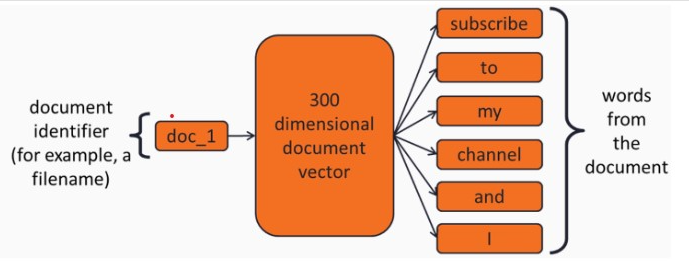
- doc2vector : 문서 하나를 하나의 vector화

In [60]:
# doc2vector
# TaggedDocument : 벡터화를 위해 document에 tag 값을 붙여주는 함수(?)
tagged_corpus_list = []
for i, token in enumerate(df[f'{column_name}']):
    tag = 'document {}'.format(i)
    tagged_corpus_list.append(TaggedDocument(tags = [tag], words = token))

In [61]:
tagged_corpus_list[0]

TaggedDocument(words=['poor', 'cooling'], tags=['document 0'])

##### 1-2) doc2vec 학습
    <model 하이퍼파라미터 값>
    # vector_size : 생성할 문서 벡터의 크기
    # alpha: 모델 학습시 초기 학습률 0.025는 일반적으로 사용됨
    # min_alpha: 학습 과정에서 alpha 값을 이 값으로 줄여나가게 됩니다
    # window : 문맥 윈도우 크기, 주변 몇개의 단어의 문맥을 고려하여 학습하는가

In [63]:
# (변경 옵션)하이퍼파라미터 값은 실습 때 사용한 그대로 가져와서 임시로 사용 
model = doc2vec.Doc2Vec(vector_size = 100, alpha = 0.025, min_alpha = 0.025, window = 5)

In [64]:
# 모델 학습
# (변경 옵션) epoch 값도 그대로 가져와서 임시로 사용
# epoch : 모델을 몇번 돌려서 학습할 것인가
model.build_vocab(tagged_corpus_list)
model.train(tagged_corpus_list, total_examples = model.corpus_count, epochs = 5)

In [65]:
# 벡터 값 데이터 프레임에 추가
vector_list = []
for i in tqdm(range(len(df))) :
    doc2vec = model.dv['document {}'.format(i)]
    vector_list.append(doc2vec)
df['vector'] = vector_list
df.head()

100%|██████████| 1147/1147 [00:00<00:00, 573883.66it/s]


,Unnamed: 0,text,state,date,star,hp_data,vector
0,0,"[poor, cooling]","[certify, buyer, darbhanga]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige...","[-0.008985013, -0.004112258, -0.0067505944, 0...."
1,1,"[good, product]","[certify, buyer, bangarapet]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige...","[-0.005500856, -0.0031780095, -0.005997241, 0...."
2,2,"[bad, experience, buy, filp, kart, heat, issue...","[certify, buyer, coimbatore]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige...","[-0.017714534, -0.0040162536, 0.016523743, -0...."
3,3,"[bad, quality, wast, money, return, option]","[certify, buyer, tirupati]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige...","[-0.008869264, 0.010118299, 0.0059509804, 0.00..."
4,4,"[refrigerator, base, fit, properly]","[certify, buyer, noida]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige...","[-0.012462162, -0.003934114, 8.197338e-05, -0...."


#### 2) 병합 계층적 클러스터링

##### 2-1) ward 기준으로 덴드로그램 작성
- ward : 두 클러스터를 합쳤을 때 변화량의 제곱을 계산하여 거리를 구하는 방식
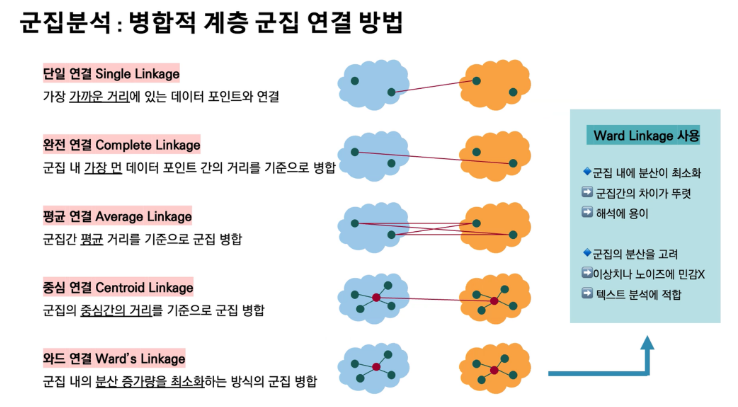

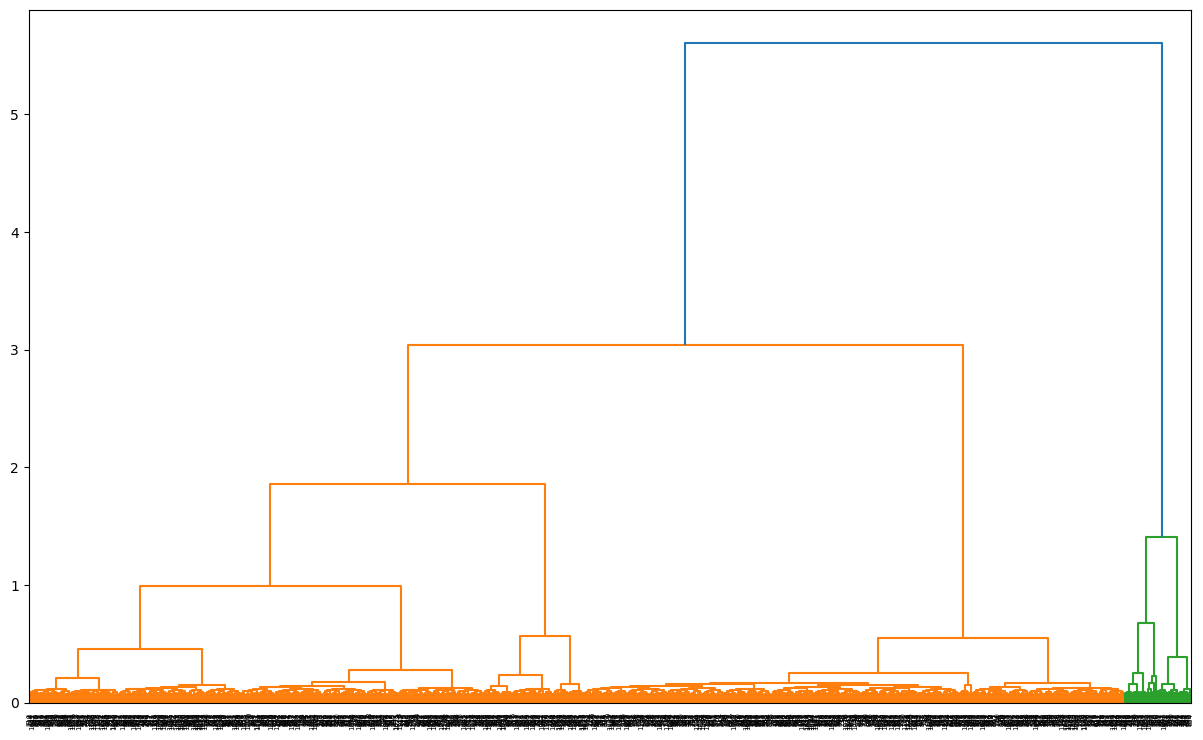

In [68]:
linked = linkage(list(df['vector']), 'ward')
plt.figure(figsize = (15,9))
dendrogram(linked,
           orientation = 'top', # 방향 위쪽으로 그려짐
           distance_sort = 'descending', # 내림차순 정렬
           show_leaf_counts=True
          )
plt.show()

##### 2-2) 실루엣 지수 확인
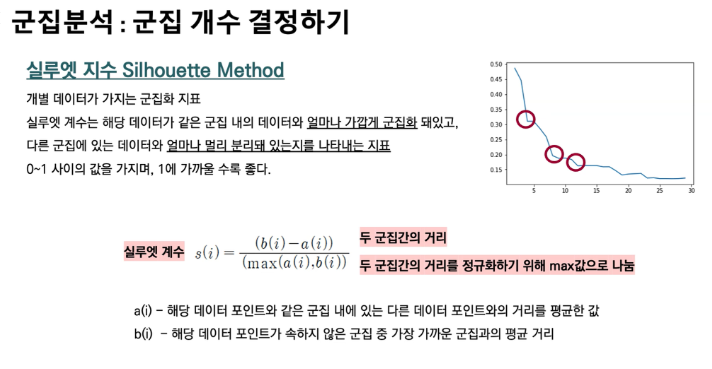

100%|██████████| 28/28 [00:01<00:00, 17.69it/s]


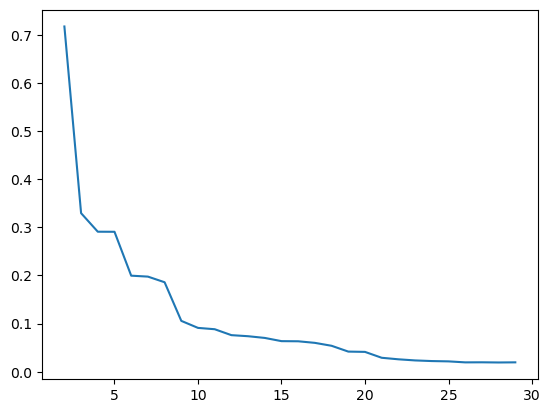

In [70]:
# 실루엣 그래프 작성
# range(2,30)으로 살펴볼 클러스터 갯수 지정
# (변경 옵션) 즉, (2,30)

n_cluster = []
s_score = []
for i in tqdm(range(2, 30)) :
    cluster = AgglomerativeClustering(n_clusters = i, linkage = 'ward')
    cluster_label = cluster.fit_predict(list(df['vector']))
    score = silhouette_score(list(df['vector']), cluster_label)

    n_cluster.append(i)
    s_score.append(score)
plt.plot(n_cluster, s_score)

In [71]:
# 테이블로 좀 더 정량적인 값 확인
result = pd.DataFrame({'n_cluster' : n_cluster, 'score' : s_score})
result

,n_cluster,score
0,2,0.717431
1,3,0.329510
2,4,0.290975
3,5,0.290822
4,6,0.199632
5,7,0.197684
6,8,0.185978
7,9,0.105715
8,10,0.091125
9,11,0.088356


##### 2-3) 가장 적절한 클러스터링 갯수 DataFrame에 삽입
- 덴드로그램과 실루엣을 기반으로 적절한 클러스터링 갯수 결정
- 아래 코드는 임의로 6을 지정

In [73]:
# (변경 옵션) n_clusters = 6
cluster = AgglomerativeClustering(n_clusters = 6, linkage = 'ward')
cluster_label = cluster.fit_predict(list(df['vector']))

df['cluster'] = cluster_label
df['cluster'].value_counts()

cluster
2    535
5    239
3    210
1     97
4     34
0     32
Name: count, dtype: int64

In [74]:
df.head()

,Unnamed: 0,text,state,date,star,hp_data,vector,cluster
0,0,"[poor, cooling]","[certify, buyer, darbhanga]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige...","[-0.008985013, -0.004112258, -0.0067505944, 0....",5
1,1,"[good, product]","[certify, buyer, bangarapet]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige...","[-0.005500856, -0.0031780095, -0.005997241, 0....",2
2,2,"[bad, experience, buy, filp, kart, heat, issue...","[certify, buyer, coimbatore]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige...","[-0.017714534, -0.0040162536, 0.016523743, -0....",3
3,3,"[bad, quality, wast, money, return, option]","[certify, buyer, tirupati]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige...","[-0.008869264, 0.010118299, 0.0059509804, 0.00...",5
4,4,"[refrigerator, base, fit, properly]","[certify, buyer, noida]","[month, ago]",1,"[lg, direct, cool, single, door, star, refrige...","[-0.012462162, -0.003934114, 8.197338e-05, -0....",5


#### 3) TF-IDF 
- 문서 내에서 어떤 단어가 얼마나 중요한지를 평가하는 데 사용되는 방법
- 클러스터링한 클러스터 중 어떤 클러스터를 사용할건지 분석
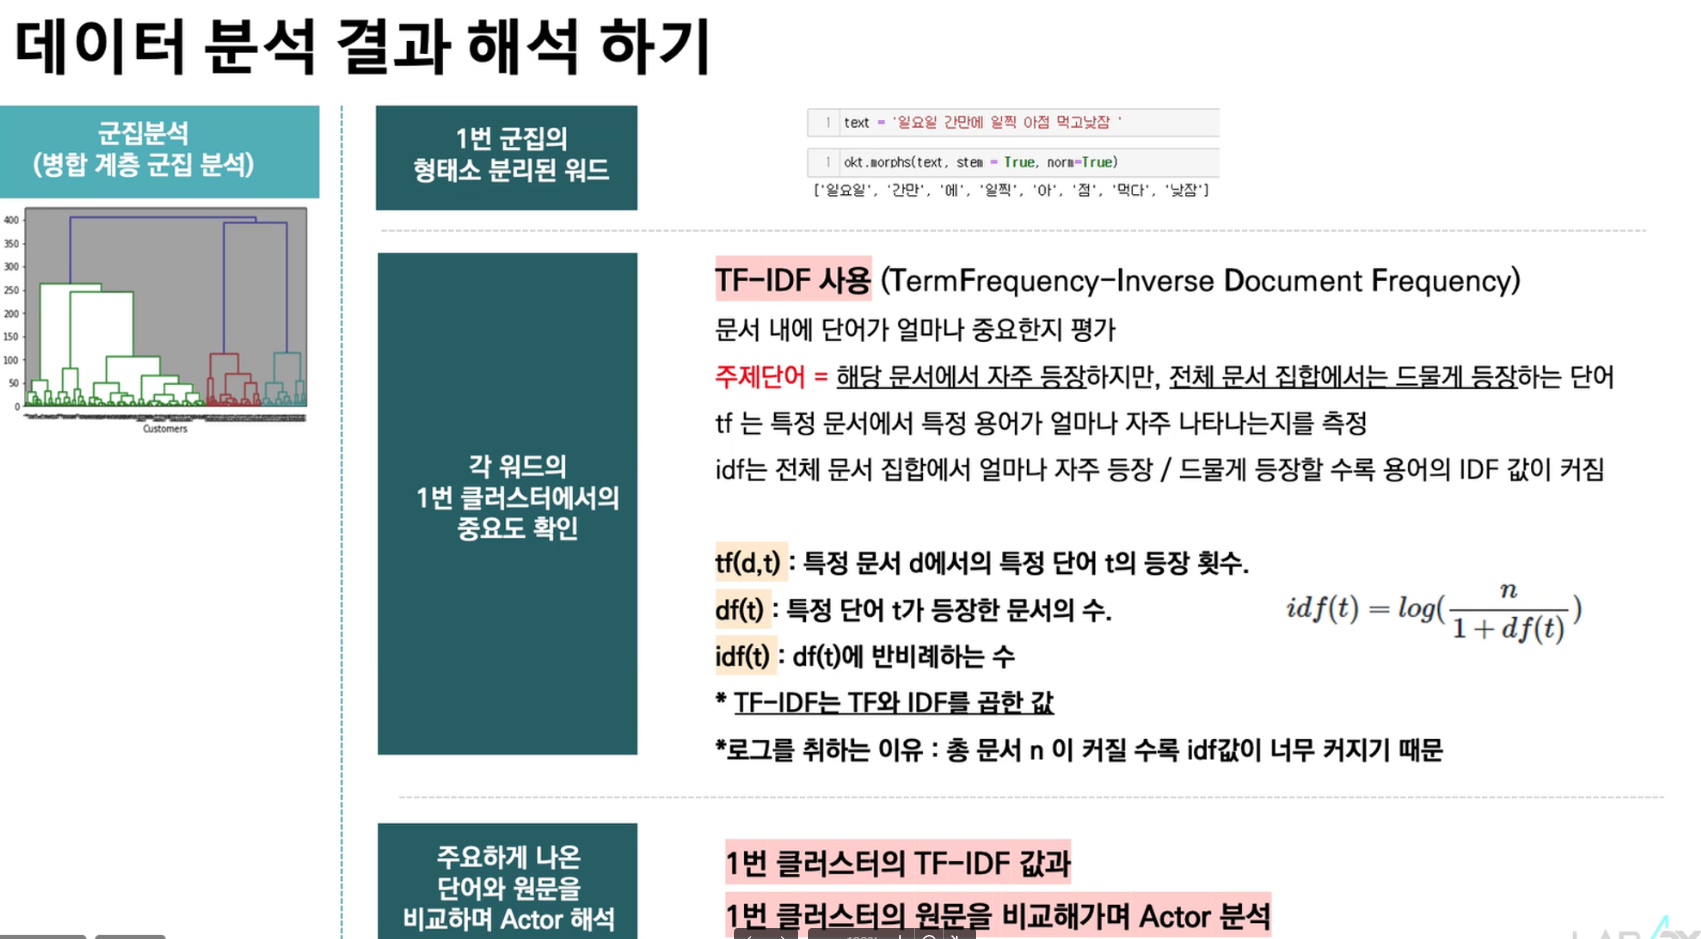

##### 3-1) TF-IDF 계산
- 각 클러스터 마다 tfidf가 높은 워드들 찾기
- 각 클러스터들을 하나의 문서로 가정하여 tf-idf 값 추출

In [77]:
all_document = []
for i in df['cluster'].unique() :
    pos_tagged = df[df['cluster'] == i][f'{column_name}'] # 분석할 텍스트 데이터 열 지정해야 합니다. 여기선 ['text']가 해당
    cluster_document = ''
    for pos in pos_tagged :
        doc = ' '.join(pos)
        cluster_document += doc

    all_document.append(cluster_document)
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_document)
feature = vectorizer.get_feature_names_out()
dense = tfidf_matrix.todense()

##### 3-2) 데이터프레임으로 만들고 정렬

In [79]:
tf_idf_df = pd.DataFrame(dense, columns = feature)
tf_idf_df.head()

aathe      able  abnormal    accept  acceptable  accessorynoise  \
0  0.000000  0.000000  0.000000  0.000000     0.00000        0.026857   
1  0.053553  0.000000  0.000000  0.000000     0.00000        0.000000   
2  0.000000  0.000000  0.000000  0.000000     0.01473        0.000000   
3  0.000000  0.012467  0.036016  0.036016     0.00000        0.000000   
4  0.000000  0.033581  0.000000  0.000000     0.00000        0.000000   

   accommodate  accumulate  additional   address  adjust  adjustment  \
0     0.000000    0.026857         0.0  0.000000     0.0         0.0   
1     0.000000    0.000000         0.0  0.000000     0.0         0.0   
2     0.000000    0.000000         0.0  0.000000     0.0         0.0   
3     0.036016    0.000000         0.0  0.018008     0.0         0.0   
4     0.000000    0.000000         0.0  0.000000     0.0         0.0   

        ago  aheaddeliver  aheadextremely     alarm  alone      alot  \
0  0.000000           0.0             0.0  0.026857    0.0  0.000000   
1  0.000000           0.0             0.0  0.000000    0.0  0.000000   
2  0.000000           0.0             0.0  0.000000    0.0  0.029460   
3  0.000000           0.0             0.0  0.000000    0.0  0.014767   
4  0.019887           0.0             0.0  0.000000    0.0  0.000000   

   alotcool  alotquality   already      also    always   amazing    amount  \
0  0.000000     0.000000  0.000000  0.023843  0.000000  0.000000  0.022023   
1  0.000000     0.000000  0.000000  0.035658  0.000000  0.026777  0.000000   
2  0.017963     0.017963  0.000000  0.039870  0.024872  0.000000  0.029460   
3  0.000000     0.000000  0.000000  0.047963  0.000000  0.000000  0.000000   
4  0.000000     0.000000  0.072758  0.021531  0.016790  0.000000  0.000000   

    another    anyone  anything  anythingand    anyway    appear  \
0  0.000000  0.000000  0.000000          0.0  0.022023  0.000000   
1  0.000000  0.000000  0.000000          0.0  0.021957  0.000000   
2  0.062181  0.017963  0.000000          0.0  0.000000  0.000000   
3  0.024934  0.000000  0.000000          0.0  0.000000  0.014767   
4  0.016790  0.000000  0.039775          0.0  0.000000  0.039775   

   appearancenice  appliance     april      area  areabody  areadoor  \
0        0.026857        0.0  0.000000  0.026857  0.000000  0.000000   
1        0.000000        0.0  0.000000  0.000000  0.000000  0.000000   
2        0.000000        0.0  0.000000  0.000000  0.017963  0.017963   
3        0.000000        0.0  0.000000  0.000000  0.000000  0.000000   
4        0.000000        0.0  0.024253  0.000000  0.000000  0.000000   

   areaordered  arrangement    arrive        as       ask   atleast  attitude  \
0     0.000000     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1     0.000000     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2     0.000000     0.017963  0.000000  0.000000  0.000000  0.000000  0.000000   
3     0.018008     0.000000  0.000000  0.014767  0.000000  0.000000  0.000000   
4     0.000000     0.000000  0.019887  0.019887  0.039775  0.039775  0.019887   

   attractivenice  authorised  automatically  automaticallyproduct  \
0        0.000000    0.000000            0.0              0.000000   
1        0.026777    0.000000            0.0              0.026777   
2        0.000000    0.000000            0.0              0.000000   
3        0.000000    0.054024            0.0              0.000000   
4        0.000000    0.000000            0.0              0.000000   

   automaticallywhen  available  availablelg  \
0           0.044046   0.000000     0.000000   
1           0.021957   0.000000     0.000000   
2           0.000000   0.024872     0.017963   
3           0.000000   0.024934     0.000000   
4           0.000000   0.000000     0.000000   

   avaragemalfunctiongoodnothinggoodoknice   average     away   awesome  \
0                                 0.000000  0.000000  0.00000  0.044046   
1                                 0.026777 

In [80]:
tf_idf_df_transposed = tf_idf_df.T
tf_idf_df_transposed

,0,1,2,3,4,5
aathe,0.000000,0.053553,0.000000,0.000000,0.000000,0.000000
able,0.000000,0.000000,0.000000,0.012467,0.033581,0.012513
abnormal,0.000000,0.000000,0.000000,0.036016,0.000000,0.000000
accept,0.000000,0.000000,0.000000,0.036016,0.000000,0.000000
acceptable,0.000000,0.000000,0.014730,0.000000,0.000000,0.044463
accessorynoise,0.026857,0.000000,0.000000,0.000000,0.000000,0.000000
accommodate,0.000000,0.000000,0.000000,0.036016,0.000000,0.000000
accumulate,0.026857,0.000000,0.000000,0.000000,0.000000,0.000000
additional,0.000000,0.000000,0.000000,0.000000,0.000000,0.108445
address,0.000000,0.000000,0.000000,0.018008,0.000000,0.000000


In [81]:
# 각 클러스터마다 TF-IDF 결과를 CSV 파일로 저장해서 비교 분석 
for i in tqdm(tf_idf_df_transposed.columns) :
    tf_idf_data = tf_idf_df_transposed[i].sort_values(ascending = False)
    data = {'word':tf_idf_data.index, 'tf-idf':tf_idf_data.values}
    data_df = pd.DataFrame(data)
    data_df.to_csv('cluster{}_tf-idf.csv'.format(i), encoding = 'utf-8-sig')
data_df.head() # 마지막 클러스터에 대한 DataFrame

100%|██████████| 6/6 [00:00<00:00, 333.32it/s]


,word,tf-idf
0,fridge,0.224648
1,bottle,0.200208
2,slot,0.162668
3,product,0.152440
4,door,0.144417


### 5. LDA 분석
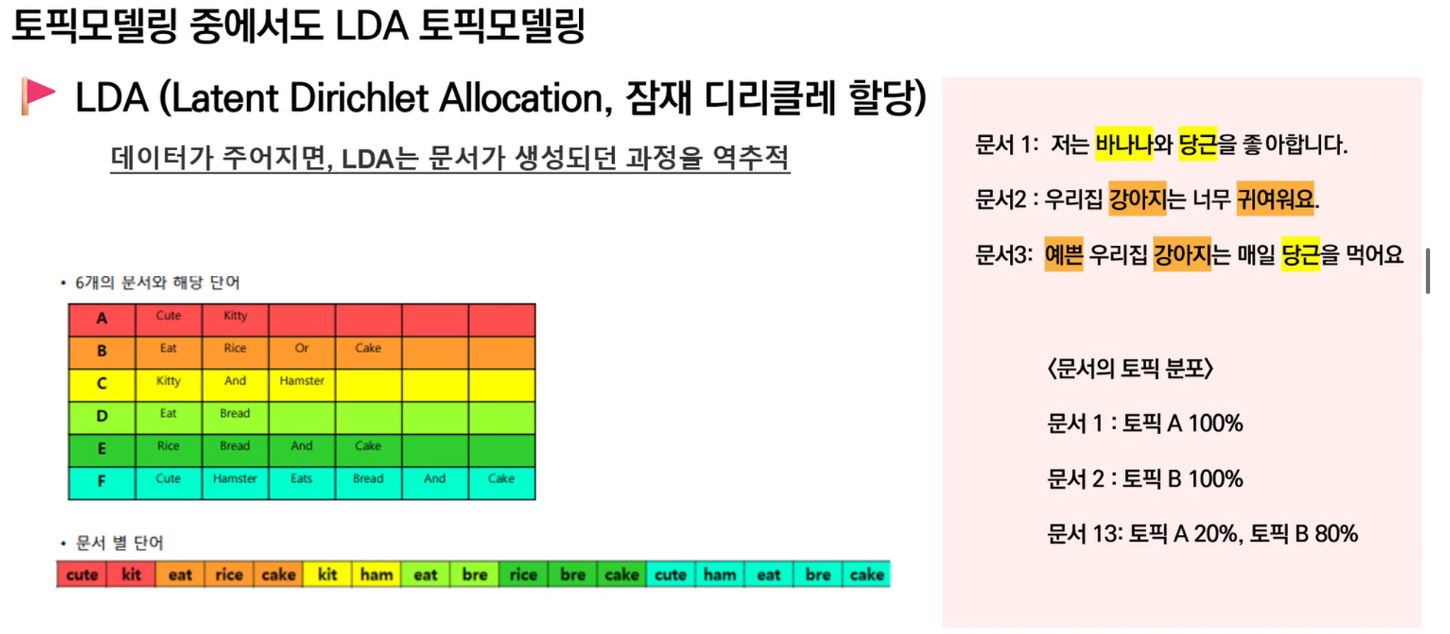

#### ✨✨분석 진행할 클러스터 선정
- 클러스터 선정 파트에서 분석한 데이터를 기반으로! 여기서 최종적으로 LDA 분석 진행할 클러스터 선정!!
- 해당 코드는 예시로 0번째 클러스터를 선택
- 만약 클러스터 분류 없이 바로 LDA 분석을 진행하고 싶으시다면 '4. 클러스터 선정'을 건너띄고 df_cluster = df.copy()로 아래 코드 수정 후에 진행하시면 됩니다. 

In [84]:
df_cluster = df[df['cluster']==0].copy() # 참고 : https://emilkwak.github.io/pandas-dataframe-settingwithcopywarning
df_cluster.head()

,Unnamed: 0,text,state,date,star,hp_data,vector,cluster
30,30,"[product, ok, small, family, regular, usage, h...","[certify, buyer, muthur]","[day, ago]",3,"[lg, direct, cool, single, door, star, refrige...","[-0.038369436, 0.021194542, 0.02995642, -0.028...",0
254,254,"[third, class, product, give, flipkart, since,...","[certify, buyer, mira, bhayandar]","[month, ago]",1,"[lg, frost, free, double, door, star, converti...","[-0.03430158, 0.012499859, 0.026721971, -0.048...",0
300,300,"[rack, use, keep, water, bottle, rest, rack, d...","[certify, buyer, hardoi]",[jul],1,"[lg, frost, free, double, door, star, converti...","[-0.051381286, 0.01682827, 0.029862653, -0.055...",0
303,303,"[receive, lot, defective, issue, freeze, somet...","[certify, buyer, rajkot]",[jun],1,"[lg, frost, free, double, door, star, converti...","[-0.033870123, 0.0103080915, 0.03469876, -0.03...",0
319,319,"[extremely, dissatisfied, lg, refrigerator, ma...","[certify, buyer, ahmedabad]",[may],2,"[lg, frost, free, double, door, star, converti...","[-0.021006059, 0.018008754, 0.019466469, -0.03...",0


#### 1) 전체 단어의 사전 만들고 각 문서에 매칭
- 코드 그대로 따라했는데 각 문서에 매칭한다는 내용은 잘 모르겠어요

In [86]:
all_documents=list(df_cluster[f'{column_name}']) # 'text' 컬럼 지정
dictionary=Dictionary(all_documents)
# dictionary.token2id # 확인용

In [87]:
corpus=[]
for doc in all_documents:
    corpus.append(dictionary.doc2bow(doc))
corpus[0] #ID 값, 빈도

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 2),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 2),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 2),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1)]

#### 2) LDA 모델 만들기

##### 2-1) LDA 토픽개수 선정
-  perplexcity & coherence
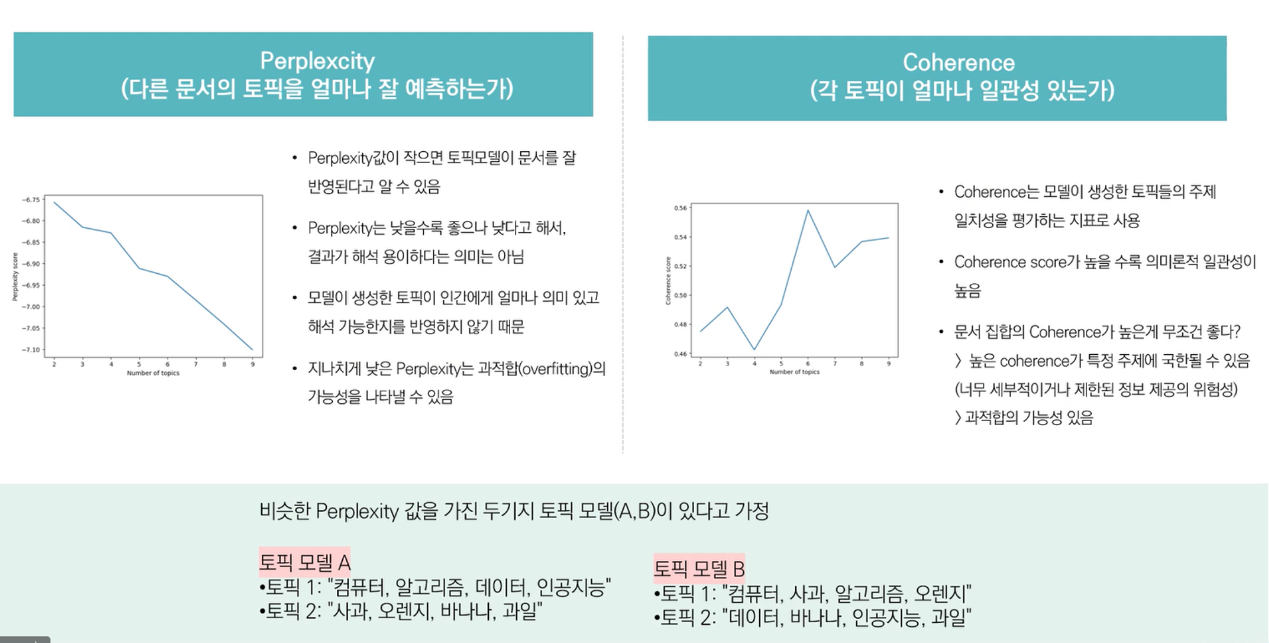
- 토픽개수 선정 기준 (잘 기억이 안나는데 여기서 말하는 클러스터수가 토픽개수라는 의미이지 않을까하는...)
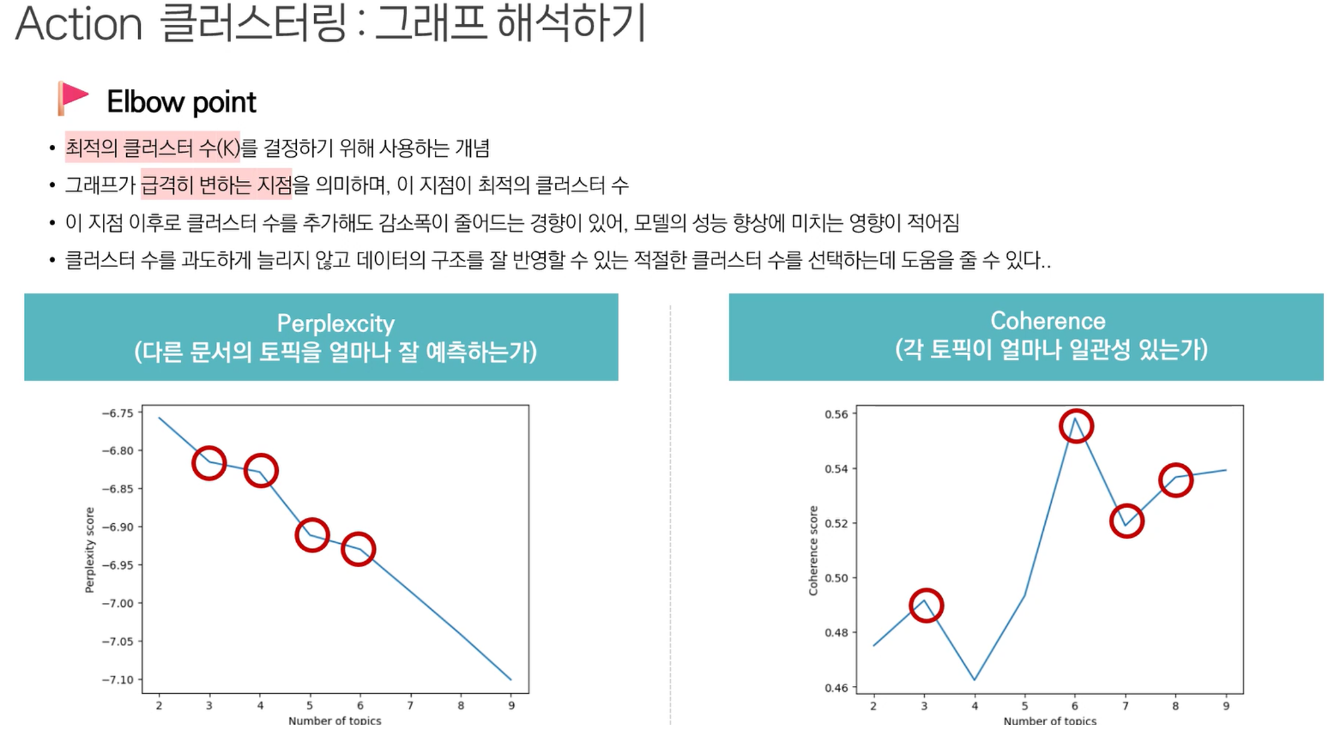

###### 2-1-1) Perplexity 그래프 만들기

Text(0, 0.5, 'Perplexity score')

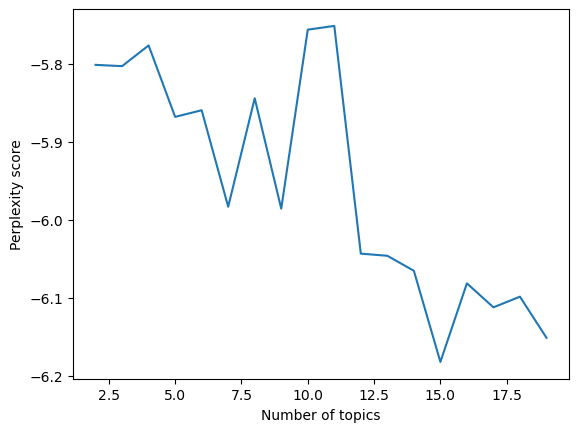

In [91]:
random_seed = 1 # (변경 옵션) LDA는 확률형 모델이라 난수 통제 필요. 임시적으로 1 지정
perplex_values=[]

# (변경 옵션) range(2,20)의 범위로 LDA 모델 생성 후 perplexity 값들 저장
for i in range(2,20):
    ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary, random_state=random_seed)
    perp_v=ldamodel.log_perplexity(corpus) # 결과값
    perplex_values.append(perp_v)

# 시각화
x= range(2,20)
plt.plot(x, perplex_values)
plt.xlabel('Number of topics')
plt.ylabel('Perplexity score')

###### 2-1-2) Coherence 그래프 만들기 -> 시간이 상당히 소요되니 볼 필요 없으면 주석 처리 추천

Text(0, 0.5, 'Cohearence score')

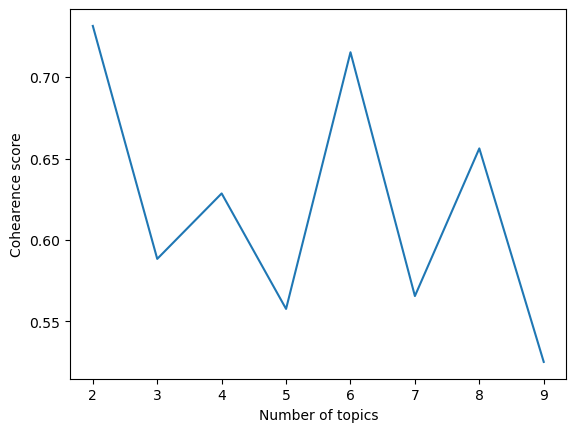

In [93]:
random_seed = 1 # (변경 옵션) LDA는 확률형 모델이라 난수 통제 필요. 임시적으로 1 지정
cohearence_values=[]

# (변경 옵션) range(2,10)의 범위로 LDA 모델 생성 후 coherence 값들 저장
for i in range(2,10):
    ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
    cohearence_model=CoherenceModel(model=ldamodel, texts=all_documents, dictionary=dictionary, topn=i)
    cohearence_score=cohearence_model.get_coherence()
    cohearence_values.append(cohearence_score)

# 시각화
x=range(2,10)
plt.plot(x, cohearence_values)
plt.xlabel('Number of topics')
plt.ylabel('Cohearence score')

##### 2-2) 선정한 토픽 개수로 Action넘버 매칭

In [95]:
topic_n = 5 # 선정한 토픽 개수
random_seed = 1
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = topic_n, id2word = dictionary, random_state = random_seed, passes = 5)

In [96]:
action_align=[]

for doc in tqdm(ldamodel.get_document_topics(corpus)):
    label=[]
    value=[]

    for score in doc:
        label.append(score[0])
        value.append(score[1]) # label 값, value값 분리

    max_index=np.argmax(value)
    action_n=label[max_index]
    action_align.append(action_n)

100%|██████████| 32/32 [00:00<00:00, 5332.45it/s]


In [97]:
ldamodel.get_document_topics(corpus)[0]

[(2, 0.97813255)]

In [98]:
df_cluster['action_cluster'] = action_align
# df_cluster

#### 3) LDA 시각화 (LDAvis)
- 원의 크기 : 토픽의 단어들이 얼마나 속해 있고 어떻게 분포 되어있는지
- 원의 거리 : 토픽 간의 유사성 (두 개의 원이 겹친다면 , 두 개의 토픽은 유사한 토픽이라는 의미)
- λ  =1 일수록,
토픽 별로 가장 자주 등장하는 단어들을 우선적으로 키워드로 선택한다는 의미
- λ = 0 일수록,
토픽 간에 차이가 많이 나는 단어를 선택한다는 의미 (해당 토픽에서 많이 등장한 단어)

In [100]:
prepared_data = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(prepared_data, 'ldavis_actor.html') # html로 저장
pyLDAvis.display(prepared_data)

##### 3-1 LDA 분석을 위한 후작업
- LDAvis(시각화 결과)와 LDA모델의 토픽 넘버가 다르기 때문에 이를 매칭하는 작업
- LDAvis 결과와 LDA모델의 결과를 보고 매칭
- 감성 분석을 위한 단계?인 듯하지만 일단 코드에 포함

In [102]:
# LDA 모델 토픽 넘버 확인
topics = ldamodel.show_topics(num_topics=-1, formatted=True)
topics

[(0,
  '0.039*"flipkart" + 0.030*"product" + 0.030*"option" + 0.026*"face" + 0.023*"door" + 0.022*"issue" + 0.022*"good" + 0.022*"lg" + 0.021*"service" + 0.020*"con"'),
 (1,
  '0.028*"fridge" + 0.019*"refrigerator" + 0.018*"make" + 0.017*"small" + 0.016*"purchase" + 0.016*"online" + 0.016*"need" + 0.015*"review" + 0.012*"lg" + 0.011*"year"'),
 (2,
  '0.033*"water" + 0.033*"bottle" + 0.025*"rack" + 0.023*"product" + 0.017*"keep" + 0.017*"purpose" + 0.017*"ml" + 0.017*"store" + 0.016*"cool" + 0.016*"issue"'),
 (3,
  '0.038*"fridge" + 0.023*"time" + 0.022*"machine" + 0.022*"small" + 0.021*"make" + 0.018*"freezer" + 0.018*"sound" + 0.018*"cool" + 0.018*"big" + 0.015*"like"'),
 (4,
  '0.058*"tray" + 0.038*"door" + 0.035*"slot" + 0.026*"fridge" + 0.024*"freezer" + 0.024*"height" + 0.024*"additional" + 0.020*"water" + 0.020*"deep" + 0.016*"inside"')]

In [103]:
# LDAvis와 LDA모델의 결과를 비교하며 매칭
# 참고로 아래는 단순히 예시이기 때문에 엉망인 매칭입니다.
new_action_topic = []
for i in df_cluster.action_cluster :
    if i == 4 : # 처음에 설정한 액션 토픽 넘버
        n = 1 # vis에서 나온 토픽 넘버
    elif i == 1 :
        n = 2
    elif i == 0 :
        n = 3
    elif i == 2:
        n = 4
    else :
        n = 5
    new_action_topic.append(n)

# df_cluster['action_cluster'] = new_action_topic # 이건 감성 분석을 위한 단계 아닌가..?